**1.Importing HDBSCAN and Folium**


In [1]:
!pip install hdbscan

     |████████████████████████████████| 4.7MB 5.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2301811 sha256=8a9ac172ef9f468c0443c21329e895e559d89de85df8758d58878b3da7dfb915
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


In [2]:
!pip install folium

**2. Importing other Important libraries used in the project**

In [3]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

**Task 1: Exploratory Data Analysis**


In [8]:
df = pd.read_csv('/content/sample_data/taxi_data.csv')
df.head()


LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [9]:
df.duplicated(subset=['LON', 'LAT']).values.any()


True

In [10]:
df.isna().values.any()

True

Dropping all the NA data

In [12]:

print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (823, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [13]:
df.head()


LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

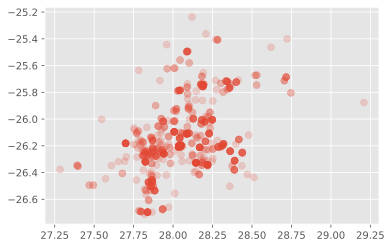

In [16]:
X = np.array(df[['LON', 'LAT']], dtype='float64')
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

Task 2: Visualizing Geographical Data

In [17]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, 
               tiles='Stamen Toner')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT, row.LON],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.NAME),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)

m    

**Task 3:Clustering Strength / Performance Metric**



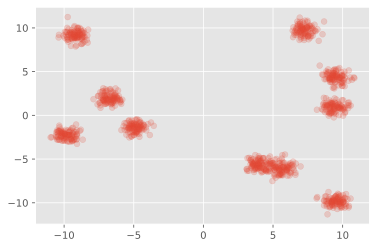

In [19]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2, 
                        cluster_std=0.5, random_state=4)

plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha=0.2)


In [21]:
class_predictions = np.load('/content/sample_data/sample_clusters.npy')


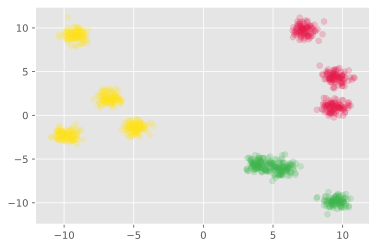

In [22]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [23]:
silhouette_score(X_blobs, class_predictions)


0.6657220862867241

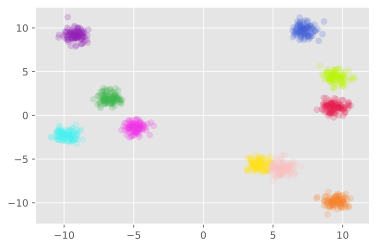

In [25]:
class_predictions = np.load('/content/sample_data/sample_clusters_improved.npy')
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [26]:
silhouette_score(X_blobs, class_predictions)


0.7473587799908298

**Task 4:K-Means Clustering**

In [27]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, 
                        n_features=2, cluster_std=1, random_state=4)

data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [28]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [62]:
X = np.array(df[['LON', 'LAT']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

df.head()


LON       LAT                          NAME  CLUSTER_kmeans70
0  28.17858 -25.73882         11th Street Taxi Rank                15
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                15
2  27.83239 -26.53722          Adams Road Taxi Rank                 5
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                33
4  28.10144 -26.10567      Alexandra Main Taxi Rank                18

In [74]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            #popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fillColor=cluster_colour
        ).add_to(m)
        
    return m

m = create_map(df, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=99
Silhouette Score: 0.2992028900672389


In [75]:
m

In [76]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}')

100%|██████████| 98/98 [00:30<00:00,  3.22it/s]

K=98
Silhouette Score: 0.6971995093340411


**Task 5: DBSCAN**

In [69]:
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])

new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])

In [77]:

model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions
df.head()

LON       LAT  ... CLUSTER_kmeans70  CLUSTERS_DBSCAN
0  28.17858 -25.73882  ...               15                0
1  28.17660 -25.73795  ...               15                0
2  27.83239 -26.53722  ...                5               -1
3  28.12514 -26.26666  ...               33               -1
4  28.10144 -26.10567  ...               18                1

[5 rows x 5 columns]

In [78]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            #popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fillColor=cluster_colour
        ).add_to(m)
        
    return m
    
m = create_map(df, 'CLUSTERS_DBSCAN')

    
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138250288208
Silhouette outliers as singletons: 0.5667489350583482


In [79]:
m

**Task 6: HDBSCAN**

In [80]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, 
                        cluster_selection_epsilon=0.01)
#min_cluster_size
#min_samples
#cluster_slection_epsilon

class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [81]:

m = create_map(df, 'CLUSTER_HDBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504356844786
Silhouette outliers as singletons: 0.638992483305273


**Task 7: Addressing Outliers**

In [84]:
classifier = KNeighborsClassifier(n_neighbors=1)
df_train = df[df.CLUSTER_HDBSCAN!=-1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON', 'LAT']], dtype='float64')

classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [85]:
predictions = classifier.predict(X_predict)
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions


m = create_map(df, 'CLUSTER_hybrid')
m

In [87]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126494706486


Text(0.5, 0, 'Cluster Sizes')

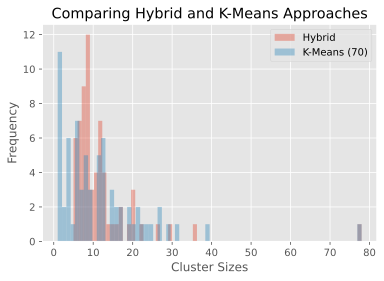

In [88]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4, 
                                              label='Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4,
                                               label='K-Means (70)')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Sizes')